In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_io as tfio
import os
import tensorflow as tf
import cv2
import datetime
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras import datasets, layers, models
print (tf.__version__)

2.1.0


In [2]:
# read file description csv
def read_file_csv(label_dir):
    return pd.read_csv(label_dir, 
                usecols=['patient_id','mass_shape','pathology','ROI_mask_file_path'])

In [3]:
def load_label(label_df):
    lab_y =label_df.pathology.fillna('UNDEFINED')
    categories =label_df.pathology.fillna('UNDEFINED')
    categories = categories.unique()
    categories = pd.Series(range(0,len(categories)), index=categories)
    for items in categories.iteritems(): 
        lab_y = lab_y.replace(items[0], items[1])
    lab_y = tf.keras.utils.to_categorical(lab_y, num_classes=len(categories), dtype='float32')
    lab_y = tf.convert_to_tensor(lab_y, dtype=tf.float32)
    return lab_y, categories

In [4]:
def print_data(imgs_x, x_axe=2, y_axe=2):
    fig, axes = plt.subplots(x_axe, y_axe, figsize=(15,15))
    k = 0
    for i in range (0, x_axe):
        for j in range (0, y_axe):
            axes[i,j].imshow(np.squeeze(imgs_x[k].numpy()[:,:,0]), cmap='gray')
            axes[i,j].set_title('image')
            k += 1

In [5]:
#def save_compressed_normalize_data(numArray):
    #np.savez_compressed("../data/CBIS-DDSM-ROI-VALI.npz", numArray)
    
def load_compressed_normalize_data(path):
    dict_data = np.load(path)
    return dict_data['arr_0']

In [6]:
def load_model_h5(model_path, checkpoint_path):
    new_model = tf.keras.models.load_model(model_path)
    new_model.summary()
    model.load_weights(checkpoint_path)
    return new_model

In [7]:
def print_lose(log):
    plt.plot(log.history['loss'], label='loss')
    #plt.plot(log.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Lost')
    plt.ylim([0, 2])
    plt.legend(loc='lower right')
    
def print_accuracy(log):
    plt.plot(log.history['accuracy'], label='accuracy')
    #plt.plot(log.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')

In [31]:
#-------------------------------------------------------------------------------
#  Model CNN
#-------------------------------------------------------------------------------
def normalization_data_set(path_images, path_labels):
    # rezise data trainer images
    h_size = 360
    w_size = 360
    
    print("== Normalization Data  ==============================")
    
    label_dir = read_file_csv(path_labels)
    imgs_x = load_compressed_normalize_data(path_images)
    images_x = tf.convert_to_tensor(imgs_x, dtype=tf.float32)
    labels_y, classes = load_label(label_dir)
   
    print("img_x size =", len(images_x))
    print("img_x dtype = ", images_x.shape)
    print("lab_y size =", len(labels_y))
    print("lab_y dtype = ", labels_y.shape)
    
    return images_x, labels_y

In [25]:
def model_definition_01(nameModel, num_classes, lr, reg_r, n_x=360, n_y=360, c=1):
    
    model = models.Sequential(name=nameModel)
    model.add(layers.Conv2D(name="conv2d_01", filters=12, kernel_size=(7,7), strides=(1, 1), activation='relu', input_shape=(n_x, n_y, c) ))
    model.add(layers.MaxPooling2D(name="maxp_01", pool_size=(4, 4), strides=(1,1)))
    
    model.add(layers.Conv2D(name="conv2d_02", filters=18, kernel_size=(5,5), strides=(1, 1), activation='relu'))
    model.add(layers.MaxPooling2D(name="maxp_02", pool_size=(4, 4), strides=(2,2)))
    
    model.add(layers.Conv2D(name="conv2d_03", filters=22, kernel_size=(5,5), strides=(1, 1), activation='relu'))
    model.add(layers.MaxPooling2D(name="maxp_03", pool_size=(3, 3), strides=(2,2) )) 
    
    model.add(layers.Conv2D(name="conv2d_04", filters=26, kernel_size=(3,3), strides=(1, 1), activation='relu'))
    model.add(layers.MaxPooling2D(name="maxp_04", pool_size=(2, 2), strides=(2,2)))
    
    model.add(layers.Conv2D(name="conv2d_05", filters=30, kernel_size=(3,3), strides=(1, 1), activation='relu'))
    model.add(layers.MaxPooling2D(name="maxp_05", pool_size=(2, 2), strides=(2,2)))
    
    model.add(layers.Conv2D(name="conv2d_06", filters=34, kernel_size=(3,3), strides=(1, 1), activation='relu'))
    model.add(layers.MaxPooling2D(name="maxp_06", pool_size=(2, 2), strides=(2,2))) 
    
    model.add(layers.Conv2D(name="conv2d_07", filters=38, kernel_size=(2,2), strides=(1, 1), activation='relu'))
    model.add(layers.MaxPooling2D(name="maxp_07", pool_size=(2, 2), strides=(1,1))) 
    
    l2 = tf.keras.regularizers.l2(l=reg_r)
    model.add(layers.Flatten(name="Flatten_01"))
    model.add(layers.Dense(684, name="Dense_01", kernel_regularizer=l2, activation='relu'))
    model.add(layers.Dense(3,   name="Dense_02", activation='softmax'))
    
    print("========= Compile Model  ====")
    model.compile( loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
    metrics = ["accuracy", 
                   'categorical_crossentropy',
                   tf.keras.metrics.FalseNegatives(), 
                   tf.keras.metrics.FalsePositives(), 
                   tf.keras.metrics.TrueNegatives(),
                   tf.keras.metrics.TruePositives()])
    
    model.summary()
    return model;

model_definition_01("T01", 3, 0.001, 0.001)

========= Compile Model  ====
Model: "Test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_01 (Conv2D)           (None, 354, 354, 12)      600       
_________________________________________________________________
maxp_01 (MaxPooling2D)       (None, 351, 351, 12)      0         
_________________________________________________________________
conv2d_02 (Conv2D)           (None, 347, 347, 18)      5418      
_________________________________________________________________
maxp_02 (MaxPooling2D)       (None, 172, 172, 18)      0         
_________________________________________________________________
conv2d_03 (Conv2D)           (None, 168, 168, 22)      9922      
_________________________________________________________________
maxp_03 (MaxPooling2D)       (None, 83, 83, 22)        0         
_________________________________________________________________
conv2d_04 (Conv2D)           (No

In [26]:
def model_definition_02(nameModel, num_classes, lr, reg_r, n_x=360, n_y=360, c=1):
    
    model = models.Sequential(name=nameModel)
    model.add(layers.Conv2D(name="conv_01", filters=24, kernel_size=(9,9), strides=(1, 1), activation='relu', input_shape=(360, 360, 1) ))
    model.add(layers.MaxPooling2D(name="maxp_01",  pool_size = (2, 2), strides=(2,2) ))

    model.add(layers.Conv2D(name="conv_02", filters=24, kernel_size=(9,9), strides=(1, 1), activation='relu'))
    model.add(layers.MaxPooling2D(name="maxp_02", pool_size=(3, 3), strides=(1,1) ))

    model.add(layers.Conv2D(name="conv_03", filters=48, kernel_size=(5,5), strides=(1, 1), activation='relu'))
    model.add(layers.MaxPooling2D(name="maxp_03", pool_size=(3, 3), strides=(2,2) )) 

    model.add(layers.Conv2D(name="conv_04", filters=48, kernel_size=(3,3), strides=(1, 1), activation='relu'))
    model.add(layers.MaxPooling2D(name="maxp_04", pool_size=(2, 2), strides=(2,2)))

    model.add(layers.Conv2D(name="conv_05", filters=96, kernel_size=(3,3), strides=(1, 1), activation='relu'))
    model.add(layers.MaxPooling2D(name="maxp_05", pool_size=(3, 3), strides=(2,2)))

    model.add(layers.Conv2D(name="conv_06", filters=192, kernel_size=(3,3), strides=(1, 1), activation='relu'))
    model.add(layers.MaxPooling2D(name="maxp_06", pool_size=(2, 2), strides=(2,2))) 

    model.add(layers.Conv2D(name="conv_07", filters=192, kernel_size=(3,3), strides=(1, 1), activation='relu'))
    model.add(layers.MaxPooling2D(name="maxp_07", pool_size=(2, 2), strides=(2,2))) 

    model.add(layers.Conv2D(name="conv_08", filters=96, kernel_size=(1,1), strides=(1, 1), activation='relu'))

    l2 = tf.keras.regularizers.l2(l=reg_r)
    model.add(layers.Flatten())
    model.add(layers.Dense(432, name="Dense_01", kernel_regularizer=l2, activation='relu'))
    model.add(layers.Dense(188, name="Dense_02", kernel_regularizer=l2, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    print("========= Compile Model  ====")
    model.compile( loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
    metrics = ["accuracy", 'categorical_crossentropy',
               tf.keras.metrics.FalseNegatives(), 
               tf.keras.metrics.FalsePositives(), 
               tf.keras.metrics.TrueNegatives(),
               tf.keras.metrics.TruePositives()] )
    
    
    model.summary()
    return model;
model_definition_02("T02", 3, 0.001, 0.001)

========= Compile Model  ====
Model: "T2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_01 (Conv2D)             (None, 352, 352, 24)      1968      
_________________________________________________________________
maxp_01 (MaxPooling2D)       (None, 176, 176, 24)      0         
_________________________________________________________________
conv_02 (Conv2D)             (None, 168, 168, 24)      46680     
_________________________________________________________________
maxp_02 (MaxPooling2D)       (None, 166, 166, 24)      0         
_________________________________________________________________
conv_03 (Conv2D)             (None, 162, 162, 48)      28848     
_________________________________________________________________
maxp_03 (MaxPooling2D)       (None, 80, 80, 48)        0         
_________________________________________________________________
conv_04 (Conv2D)             (None

In [12]:
def evaluate_model(model, val_img_x, val_lab_y):
    val_dataset = tf.data.Dataset.from_tensor_slices((val_img_x, val_lab_y))
    val_dataset = val_dataset.batch(64)

    print("== Evaluate Model ===================================")
    result = model.evaluate(val_dataset)
    dict(zip(model.metrics_names, result))

== Create Model =====================================
Start Time= 2020-03-25 21:54:15.197890
== Load Test dataset ================================
== Normalization Data  ==============================
img_x size = 1317
img_x dtype =  (1317, 360, 360, 1)
lab_y size = 1317
lab_y dtype =  (1317, 3)
== Normalization Data  ==============================
img_x size = 188
img_x dtype =  (188, 360, 360, 1)
lab_y size = 188
lab_y dtype =  (188, 3)
== Normalization Data  ==============================
img_x size = 190
img_x dtype =  (190, 360, 360, 1)
lab_y size = 190
lab_y dtype =  (190, 3)
== model_definition_01 ===============================
========= Compile Model  ====
Model: "Miroku-ROI-COMP-0.0.1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_01 (Conv2D)           (None, 354, 354, 12)      600       
_________________________________________________________________
maxp_01 (MaxPooling2D)       (N

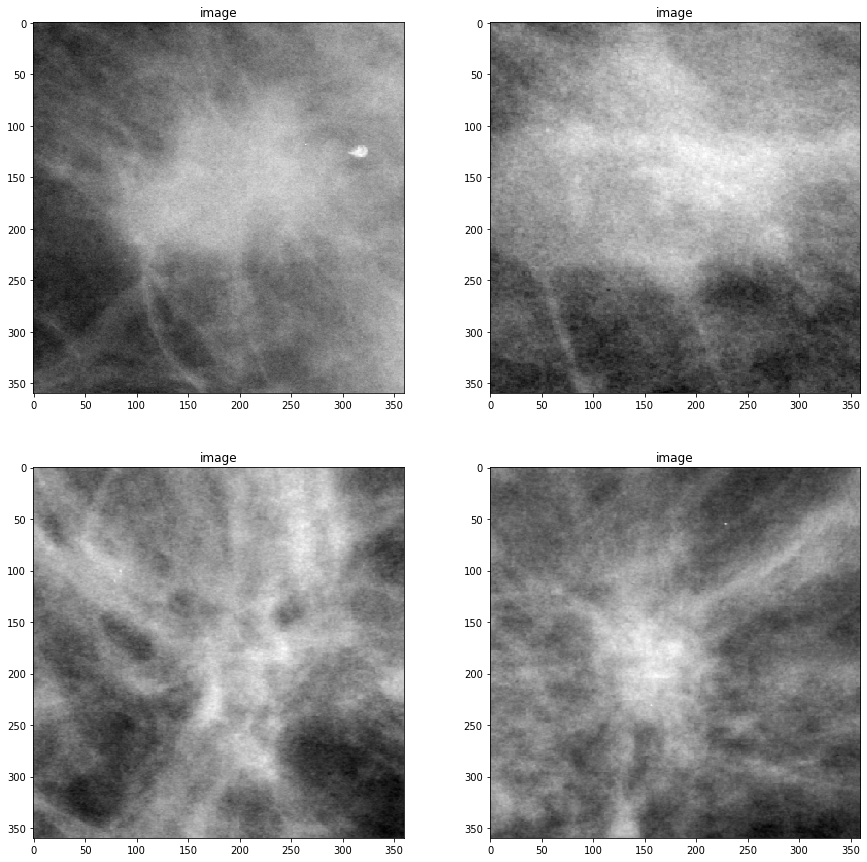

In [33]:
#Models features
nameModel = "Miroku-ROI-COMP-0.0.1"
lr = 0.000202
epochs = 300
regularizers_rate = 0.01
minibatch_size = 64
num_save_freq=64
num_classes= 3

#File seve models results
checkpoint_path = "../checkpoint/"+ nameModel + ".ckpt"
model_path = '../my_models/' + nameModel + '.h5'
weight_path = "../checkpoint/Miroku-test.ckpt"
hystory = []

# labels files
label_train_dir = '../label/mass_case_description_train_set.csv'
label_vali_dir = '../label/mass_case_description_validation_set.csv'
label_test_dir = '../label/mass_case_description_test_set.csv'

# Images files
imgs_train_dir = "../data/CBIS-DDSM-ROI.npz"
imgs_vali_dir =  "../data/CBIS-DDSM-ROI-VALI.npz"
imgs_test_dir =  "../data/CBIS-DDSM-ROI-TEST.npz"

    
d_time = datetime.datetime.now()
print("== Create Model =====================================")
print("Start Time=", d_time)

print("== Load Test dataset ================================")
train_img_x, train_lab_y = normalization_data_set(imgs_train_dir, label_train_dir) 
val_img_x, val_lab_y = normalization_data_set(imgs_vali_dir, label_vali_dir)
test_img_x, test_lab_y = normalization_data_set(imgs_test_dir, label_test_dir)



##Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Clear any logs from previous runs
!rm -rf ../logs/ 
##Using TensorBoard with Keras Model.fit
log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

print("== model_definition_01 ===============================")
model = model_definition_01(nameModel, num_classes, lr, regularizers_rate)

print("== model_definition_02 ===============================")
#model = model_definition_02(nameModel, num_classes, lr, regularizers_rate)

##Reload a fresh Keras model from the saved model
#model = tf.keras.models.load_model(model_path)
#model.load_weights(weight_path)

print_data(train_img_x[:10])

print("== Train Model ======================================")

hystory = model.fit(x = train_img_x, 
                    y = train_lab_y, 
                    epochs =epochs,
                    batch_size = minibatch_size,
                    callbacks=[cp_callback, tensorboard_callback]) 



if hystory != []:
    print("== Save Model =======================================")
    #model.save(model_path) 
    print("== Print Lost =======================================")
    print_lose(hystory)
    print_accuracy(hystory)
    print(hystory.history)


d_time = datetime.datetime.now()
print("== End ==============================================")
print("End Time=", d_time)